[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1nKLxsi_fIen97vUcFIx2g-cIaEJSYoBJ?usp=sharing)

# Notebook #4: build an unemployment index from Twitter data

## Description:

In this notebook, you will learn how to use tweets extracted with the Tweepy API to build an unemployment index for Mexico. The method we will use consists in calculating the share of daily tweets containing a specific keyword or group of keywords (e.g. 'I lost my job'). This method is obviously simplistic and the output should not be compared with the unemployment rate defined by national statistical institutes. Yet, this index provides timely information that can help predict future unemployment trends.

### Import modules

In [1]:
import os

import matplotlib
import pandas as pd
import seaborn as sns

In [2]:
matplotlib.__version__

'3.3.2'

### Import data

We have downloaded tweets using Tweepy and the Twitter Streaming API. The latter allows developers to download a high volume of real-time tweets. For more information, please refer to the [Twitter Streaming API Documentation](https://developer.twitter.com/en/docs/tweets/filter-realtime/overview). We are unfortunately not able to share these tweets because of Twitter policy. We therefore encourage you to try the following example with tweets that you have downloaded. 

We now load the tweets and store them in a Pandas dataframe.

In [3]:
path_to_data = './path/to/your/data/folder'

In [4]:
MX_df = pd.read_csv(os.path.join(path_to_data,
                                     'your_file.csv'))

,tweet_id,created_at,text,tweet_lang,user_id,user_location,place_id,tweet_longitude,tweet_latitude,month
0,1256070856368766976,2020-05-01 04:00:03,@starsinoureyes_ We love to see this!!! Happy ...,en,591387670,CA📍NY,None,NaN,NaN,5
1,1256070877759672320,2020-05-01 04:00:08,@MocTey Es que no existe,es,420672663,"Sonora, México",None,NaN,NaN,5
2,1256070898517499904,2020-05-01 04:00:13,@mart_in_hillo me ofreció que me trajera un ch...,es,1107430830538924032,"Hermosillo, Sonora",None,NaN,NaN,5
3,1256070945489461249,2020-05-01 04:00:24,@alfonsozarate Esto es lo que buscaban chairos...,es,1072792855,"Querétaro, Querétaro Arteaga",None,NaN,NaN,5
4,1256071044227641346,2020-05-01 04:00:48,RT @soyowencruz: EXTRAÑO A MI EX ᵗʳᵉᵐᵃ ᵛⁱᵈᵃ ᵏ ...,es,885198576812470272,"Aguascalientes, México",None,NaN,NaN,5


Since we will focus on Spanish keywords, we will keep only the tweets in Spanish.

In [5]:
MX_df = MX_df.loc[MX_df['tweet_lang'] == 'es']

In [6]:
MX_df.head()

,tweet_id,created_at,text,tweet_lang,user_id,user_location,place_id,tweet_longitude,tweet_latitude,month
1,1256070877759672320,2020-05-01 04:00:08,@MocTey Es que no existe,es,420672663,"Sonora, México",None,NaN,NaN,5
2,1256070898517499904,2020-05-01 04:00:13,@mart_in_hillo me ofreció que me trajera un ch...,es,1107430830538924032,"Hermosillo, Sonora",None,NaN,NaN,5
3,1256070945489461249,2020-05-01 04:00:24,@alfonsozarate Esto es lo que buscaban chairos...,es,1072792855,"Querétaro, Querétaro Arteaga",None,NaN,NaN,5
4,1256071044227641346,2020-05-01 04:00:48,RT @soyowencruz: EXTRAÑO A MI EX ᵗʳᵉᵐᵃ ᵛⁱᵈᵃ ᵏ ...,es,885198576812470272,"Aguascalientes, México",None,NaN,NaN,5
6,1256071067212419072,2020-05-01 04:00:53,RT @bubafonck: Imagínate estar en medio de una...,es,912783976166772736,Mexico 🇲🇽,None,NaN,NaN,5


We now have a dataset of 671,875 tweets, ranging from May 1 until May 31st, 2020. 

In [7]:
MX_df.shape

(671875, 10)

In [8]:
MX_df['created_at'].min()

Timestamp('2020-05-01 04:00:00')

In [9]:
MX_df['created_at'].max()

Timestamp('2020-05-31 22:55:01')

The function below takes as input:
- `df` the data loaded above in dataframe format
- `regex` a keyword or regex in string format

It then normalizes the dates, selects all tweets containing the `regex` string argument and computes the share of tweets containing the `regex` string per day. 

In [10]:
def build_ngram_timeseries(df, regex):
    """Build time-series for input ngram."""
    # normalize date
    df['created_at'] = pd.to_datetime(df['created_at'], format='%m-%d')
    df['created_at'] = pd.DatetimeIndex(df.created_at).normalize()
    # lowercase text
    df['text'] = df['text'].str.lower()
    # build indicator 
    df['contains_ngram'] = df.text.str.contains(regex)
    df['contains_ngram'] = df['contains_ngram'].apply(lambda x: 1 if x else 0)
    # keep relevant columns, rename and set date as index
    df = df[['created_at', 'contains_ngram']]
    df.columns = ['date', 'ngram_index']
    df = df.set_index(['date'])
    return df.groupby(df.index.date).mean()

### Build and plot index

Let's do an example with the share of our Mexican tweets containing the keyword `sin trabajo` (meaning `without a job` in Spanish). 

In [11]:
df = build_ngram_timeseries(MX_df, 'sin trabajo')
df['ngram_index'] = df['ngram_index']*100
df.head(n=10)

,ngram_index
2020-05-01,0.028799
2020-05-02,0.090705
2020-05-03,0.023901
2020-05-04,0.039341
2020-05-05,0.048159
2020-05-06,0.034881
2020-05-07,0.025890
2020-05-08,0.038039
2020-05-09,0.009232
2020-05-10,0.030423


As expected, we get a daily share (between 0 and 1) of our tweets containing the expression `sin trabajo` on the time period for which we collected data, that is May 2020. We now plot this share, with time as x-axis and, the share of tweets containing the expression `sin trabajo` as y-axis.

<AxesSubplot:>

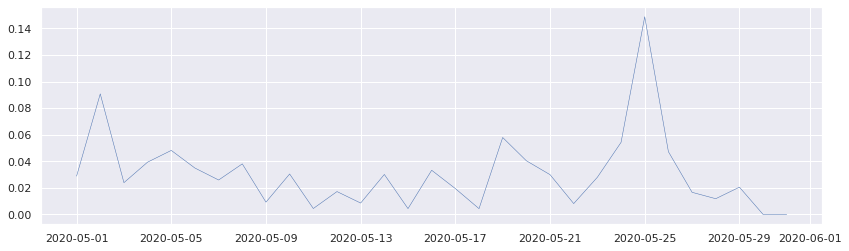

In [12]:
sns.set(rc={'figure.figsize':(14, 4)})
df['ngram_index'].plot(linewidth=0.5)

The share of Mexican tweets we collected containing the expression `sin trabajo` in May 2020 ranges from 0 to 0.14%. It is relatively constant from the beginning of May until the 21st when it starts rising, peaks on the 25th at 0.14% and then goes back down. 

## Conclusion:

In this notebook, we learned how to produce indexes based on the share of daily tweets containing specific expressions. We built a daily index using the expression `sin trabajo` on more than 671,000 Mexican tweets from May 2020. 

Moving on, while we focused on a relatively small-time period to limit computing power needs, we invite you to collect tweets for longer time periods. Also, we only focused on one expression for simplicity but feel free to try out several expressions as you see fit.